In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
from typing import Tuple, List, Dict
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  

In [3]:
df = pd.read_parquet(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\dataout_HPC\COMPRESSED_CIS_tle_data.parquet')
df.shape

(3030409, 31)

In [4]:
#samp_df = df[df['satNo'].isin([51511,55841])]
samp_df = df[df['satNo']==51511]
samp_df = samp_df.sort_values(by='epoch', ascending=False)

if samp_df['satNo'].nunique() > 1:
    orb_df = samp_df[['epoch','satNo','meanMotion','eccentricity','inclination', 'raan', 'argOfPerigee', 'meanAnomaly', 'meanMotionDot', 'meanMotionDDot', 'semiMajorAxis', 'apogee', 'perigee']]
    satNo_lst = orb_df['satNo'].unique()
else:
    orb_df = samp_df[['epoch','meanMotion','eccentricity','inclination', 'raan', 'argOfPerigee', 'meanAnomaly', 'meanMotionDot', 'meanMotionDDot', 'semiMajorAxis', 'apogee', 'perigee']]
orb_df = orb_df.set_index('epoch', drop = True)

orb_df.info(), orb_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 2024-10-10T03:42:45.176256Z to 2023-10-11T15:24:04.785984Z
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   meanMotion      853 non-null    float64
 1   eccentricity    853 non-null    float64
 2   inclination     853 non-null    float64
 3   raan            853 non-null    float64
 4   argOfPerigee    853 non-null    float64
 5   meanAnomaly     853 non-null    float64
 6   meanMotionDot   853 non-null    float64
 7   meanMotionDDot  853 non-null    float64
 8   semiMajorAxis   853 non-null    float64
 9   apogee          853 non-null    float64
 10  perigee         853 non-null    float64
dtypes: float64(11)
memory usage: 80.0+ KB


(None,
                              meanMotion  eccentricity  inclination      raan  argOfPerigee  meanAnomaly  meanMotionDot  meanMotionDDot  semiMajorAxis    apogee   perigee
 epoch                                                                                                                                                                    
 2024-10-10T03:42:45.176256Z   11.328739      0.000370      67.0926  206.9860      263.8355      96.2165  -2.300000e-07             0.0        8374.28  8377.382  8371.178
 2024-10-09T21:21:22.685760Z   11.328739      0.000371      67.0926  207.3818      263.8345      96.2175  -1.600000e-07             0.0        8374.28  8377.387  8371.173
 2024-10-09T12:52:52.704768Z   11.328739      0.000371      67.0926  207.9096      263.8467      96.2053  -2.000000e-07             0.0        8374.28  8377.390  8371.170
 2024-10-08T19:55:52.734144Z   11.328739      0.000372      67.0925  208.9652      263.7683      96.2837  -1.000000e-07             0.0   

Satcat 

In [5]:
file_path = r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\dataout_HPC\CIS_satcat.pkl'

with open(file_path,'rb') as f:
    satcat = pickle.load(f)

object_types = []

for i in range(len(satcat)):
    obj_ty = satcat[i].get('OBJECT_TYPE')
    object_types.append(obj_ty)


type_count = Counter(object_types)
type_count

Counter({'DEBRIS': 17213, 'ROCKET BODY': 3980, 'PAYLOAD': 3688, 'UNKNOWN': 41})

Anomaly Detection Model

In [ ]:
#################################################################
#               General Encoder-Decoder Model
#################################################################
"""
X = orb_df.values  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=64, shuffle=True)

#Autoencoder
class TLEAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(TLEAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = X_train_tensor.shape[1]
model = TLEAutoencoder(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
"""

More Robust Model with Visuals

In [8]:
#################################################################
#               Anom Detect Encoder-Decoder Model
#################################################################

class TLEVisualizer:
    
    @staticmethod
    def format_timestamps(timestamps, indices=None):
        if indices is not None:
            timestamps = timestamps[indices]
        if not isinstance(timestamps, pd.DatetimeIndex):
            timestamps = pd.DatetimeIndex(timestamps)
        return [ts.strftime('%Y-%m-%d %H:%M') for ts in timestamps]
    
    @staticmethod
    def plot_training_loss(losses: List[float], figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(losses, label='Training Loss')
        plt.title('Autoencoder Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    @staticmethod
    def plot_reconstruction_errors(reconstruction_errors: np.ndarray, 
                                 feature_names: List[str],
                                 figsize=(8, 5)):
        plt.figure(figsize=figsize)
        sns.boxplot(data=reconstruction_errors)
        plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
        plt.title('Distribution of Reconstruction Errors by Feature')
        plt.xlabel('Feature')
        plt.ylabel('Reconstruction Error')
        plt.tight_layout()
        plt.show()
    
    @classmethod
    def plot_anomaly_heatmap(cls, 
                            anomaly_details: Dict, 
                            feature_names: List[str],
                            timestamps,
                            max_samples: int = 50,
                            figsize=(15, 8)):

        anomalous_indices = np.where(np.any(anomaly_details['feature_anomalies'], axis=1))[0]
        
        if len(anomalous_indices) == 0:
            print("No anomalies found to visualize")
            return
        
        if len(anomalous_indices) > max_samples:
            anomalous_indices = anomalous_indices[:max_samples]
        
        z_scores = anomaly_details['z_scores'][anomalous_indices]
        
        time_labels = cls.format_timestamps(timestamps, anomalous_indices)
        
        plt.figure(figsize=figsize)

        plt.rcParams.update({
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 11,
            'xtick.labelsize': 10,
            'ytick.labelsize': 8,
            })

        sns.heatmap(z_scores, 
                   xticklabels=feature_names,
                   yticklabels=time_labels,
                   cmap='RdYlBu_r',
                   center=0)
        plt.title('Anomaly Z-Scores Heatmap')
        plt.xlabel('Feature')
        plt.ylabel('Timestamp')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_feature_timeline(data: np.ndarray,
                            anomalies: np.ndarray,
                            feature_names: List[str],
                            timestamps,
                            n_features: int = 6,
                            figsize=(15, 12)):

        if not isinstance(timestamps, pd.DatetimeIndex):
            timestamps = pd.DatetimeIndex(timestamps)
            
        n_features = min(n_features, data.shape[1])
        
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(n_features, 1, figure=fig)
        
        date_formatter = DateFormatter('%Y-%m-%d')
        
        for i in range(n_features):
            ax = fig.add_subplot(gs[i, 0])
            
            ax.plot(timestamps[~anomalies], data[~anomalies, i], 'b.', 
                   alpha=0.5, label='Normal', markersize=4)
            
            if np.any(anomalies):
                ax.plot(timestamps[anomalies], data[anomalies, i], 'r.', 
                       label='Anomaly', alpha=0.7, markersize=6)
            
            ax.set_ylabel(feature_names[i])
            ax.xaxis.set_major_formatter(date_formatter)
            ax.grid(True, alpha=0.3)
            
            if i == 0:
                ax.legend()
            if i == n_features - 1:
                ax.set_xlabel('Time')
            
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.suptitle('Feature Timeline with Anomalies')
        plt.tight_layout()
        plt.show()
    
    @classmethod
    def plot_summary(cls,
                    data: np.ndarray,
                    anomaly_details: Dict,
                    anomalies: np.ndarray,
                    feature_names: List[str],
                    timestamps,
                    losses: List[float]):
        if not isinstance(timestamps, pd.DatetimeIndex):
            timestamps = pd.DatetimeIndex(timestamps)
            
        fig = plt.figure(figsize=(20, 12))
        gs = GridSpec(2, 3, figure=fig)
        
        #Training Loss
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(losses)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        
        #Reconstruction Error
        ax2 = fig.add_subplot(gs[0, 1:])
        sns.boxplot(data=anomaly_details['reconstruction_errors'], ax=ax2)
        ax2.set_xticklabels(feature_names, rotation=45, ha='right')
        ax2.set_title('Reconstruction Error Distribution')
        ax2.grid(True, alpha=0.3)
        
        #Anomaly Timeline
        ax3 = fig.add_subplot(gs[1, :2])
        ax3.plot(timestamps[~anomalies], np.zeros(np.sum(~anomalies)), 'b.',
                label='Normal', alpha=0.5, markersize=4)
        if np.any(anomalies):
            ax3.plot(timestamps[anomalies], np.ones(np.sum(anomalies)), 'r.',
                    label='Anomaly', alpha=0.7, markersize=6)
        ax3.set_title('Anomaly Timeline')
        ax3.set_ylabel('Anomaly (1) / Normal (0)')
        ax3.set_xlabel('Time')
        ax3.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        #Feature Distribution
        ax4 = fig.add_subplot(gs[1, 2])
        feature_anomaly_counts = anomaly_details['feature_anomalies'].sum(axis=0)
        ax4.bar(range(len(feature_names)), feature_anomaly_counts)
        ax4.set_xticks(range(len(feature_names)))
        ax4.set_xticklabels(feature_names, rotation=45, ha='right')
        ax4.set_title('Anomalies per Feature')
        ax4.set_ylabel('Count')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

class TLEEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):
        super(TLEEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
    def forward(self, x):
        return self.encoder(x)

class TLEDecoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int):
        super(TLEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        return self.decoder(x)

class TLEAnomalyDetector:
    def __init__(self, input_dim: int, latent_dim: int = 8):
        print(f"Initializing detector with input_dim={input_dim}, latent_dim={latent_dim}")
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.encoder = TLEEncoder(input_dim, latent_dim).to(self.device)
        self.decoder = TLEDecoder(latent_dim, input_dim).to(self.device)
        self.scaler = StandardScaler()
        
    def visualize_results(self, data: np.ndarray, 
                         anomalies: np.ndarray,
                         anomaly_details: Dict,
                         feature_names: List[str],
                         timestamps: pd.DatetimeIndex,
                         losses: List[float]):
        visualizer = TLEVisualizer()
        
        print("Generating visualization summary...")
        visualizer.plot_summary(data, anomaly_details, anomalies, 
                              feature_names, timestamps, losses)
        
        print("\nGenerating detailed visualizations...")
        visualizer.plot_training_loss(losses)
        visualizer.plot_reconstruction_errors(anomaly_details['reconstruction_errors'], 
                                           feature_names)
        visualizer.plot_anomaly_heatmap(anomaly_details, feature_names, timestamps)
        visualizer.plot_feature_timeline(data, anomalies, feature_names, timestamps)
        
    def _validate_input_data(self, data: np.ndarray) -> None:
        if not isinstance(data, np.ndarray):
            raise TypeError(f"Expected numpy array, got {type(data)}")
        
        if len(data.shape) != 2:
            raise ValueError(f"Expected 2D array, got shape {data.shape}")
            
        if data.shape[1] != self.input_dim:
            raise ValueError(f"Expected {self.input_dim} features, got {data.shape[1]}")
            
        if np.isnan(data).any():
            raise ValueError("Input data contains NaN values")
            
        if np.isinf(data).any():
            raise ValueError("Input data contains infinite values")

    def train(self, data: np.ndarray, epochs: int = 150, batch_size: int = 32) -> List[float]:
        print(f"Starting training with data shape: {data.shape}")
        self._validate_input_data(data)
        
        scaled_data = self.scaler.fit_transform(data)
        train_data = torch.FloatTensor(scaled_data).to(self.device)
        
        optimizer = optim.Adam(list(self.encoder.parameters()) + 
                             list(self.decoder.parameters()))
        criterion = nn.MSELoss(reduction='none')
        losses = []
        
        n_batches = (len(train_data) + batch_size - 1) // batch_size  # ceil division
        print(f"Training with {n_batches} batches per epoch")
        
        for epoch in range(epochs):
            total_loss = 0
            for i in range(0, len(train_data), batch_size):
                batch = train_data[i:min(i + batch_size, len(train_data))]
                
                latent = self.encoder(batch)
                reconstructed = self.decoder(latent)
                
                loss = criterion(reconstructed, batch).mean()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / n_batches
            losses.append(avg_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
                
        return losses
    
    def detect_anomalies(self, data: np.ndarray, threshold_sigma: float = 3.769) -> Tuple[np.ndarray, Dict]:
        print(f"Detecting anomalies in data with shape: {data.shape}")
        self._validate_input_data(data)
        
        scaled_data = self.scaler.transform(data)
        test_data = torch.FloatTensor(scaled_data).to(self.device)
        
        with torch.no_grad():
            latent = self.encoder(test_data)
            reconstructed = self.decoder(latent)
        
        reconstruction_errors = torch.abs(test_data - reconstructed)
        reconstruction_errors = reconstruction_errors.cpu().numpy()
        error_mean = np.mean(reconstruction_errors, axis=0)
        error_std = np.std(reconstruction_errors, axis=0)
        error_std = np.where(error_std == 0, 1e-10, error_std)
        
        z_scores = (reconstruction_errors - error_mean) / error_std
        anomalies = np.any(np.abs(z_scores) > threshold_sigma, axis=1)
        
        anomaly_details = {
            'z_scores': z_scores,
            'feature_anomalies': np.abs(z_scores) > threshold_sigma,
            'reconstruction_errors': reconstruction_errors
        }
        
        print(f"Found {np.sum(anomalies)} anomalous samples")
        return anomalies, anomaly_details
    
    def explain_anomalies(self, anomaly_details: Dict, feature_names: List[str] = None) -> List[Dict]:
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(anomaly_details['z_scores'].shape[1])]
        
        if len(feature_names) != anomaly_details['z_scores'].shape[1]:
            raise ValueError(f"Expected {anomaly_details['z_scores'].shape[1]} feature names, got {len(feature_names)}")
            
        print(f"Generating explanations for shape {anomaly_details['z_scores'].shape}")
        explanations = []
        
        for i in range(len(anomaly_details['z_scores'])):
            if np.any(anomaly_details['feature_anomalies'][i]):
                anomalous_features = []
                for j, is_anomaly in enumerate(anomaly_details['feature_anomalies'][i]):
                    if is_anomaly:
                        anomalous_features.append({
                            'feature': feature_names[j],
                            'z_score': float(anomaly_details['z_scores'][i, j]),  
                            'reconstruction_error': float(anomaly_details['reconstruction_errors'][i, j])
                        })
                
                if anomalous_features:
                    explanations.append({
                        'sample_index': int(i),  
                        'anomalous_features': anomalous_features
                    })
                    
        print(f"Generated {len(explanations)} anomaly explanations")
        return explanations

def run_anomaly_detection(df: pd.DataFrame, feature_names: List[str] = None):
    try:

        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        data = df.values
        timestamps = df.index
        n_features = df.shape[1]
        
        input_dim = data.shape[1]
        detector = TLEAnomalyDetector(input_dim=input_dim)
        
        print("Training model...")
        losses = detector.train(data, epochs=150)
        
        print("Detecting anomalies...")
        anomalies, anomaly_details = detector.detect_anomalies(data)
        
        print("Generating explanations...")
        if feature_names is None:
            feature_names = df.columns.tolist()
        explanations = detector.explain_anomalies(anomaly_details, feature_names)
        
        print("Generating visualizations...")
        visualizer = TLEVisualizer()
        visualizer.plot_summary(data, anomaly_details, anomalies, 
                              feature_names, timestamps, losses)
        #visualizer.plot_training_loss(losses)
        #visualizer.plot_reconstruction_errors(anomaly_details['reconstruction_errors'], feature_names)
        visualizer.plot_anomaly_heatmap(anomaly_details, feature_names, timestamps, figsize =(10,5))
        visualizer.plot_feature_timeline(data, anomalies, feature_names, timestamps, n_features, (15,10))
        
        return detector, anomalies, explanations, timestamps, anomaly_details
        
    except Exception as e:
        print(f"Error during anomaly detection: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        print(f"Traceback: {traceback.format_exc()}")
        raise



Initializing detector with input_dim=11, latent_dim=8
Using device: cpu
Training model...
Starting training with data shape: (853, 11)
Training with 27 batches per epoch
Epoch [10/150], Loss: 0.343209
Epoch [20/150], Loss: 0.225768
Epoch [30/150], Loss: 0.142231
Epoch [40/150], Loss: 0.082091
Epoch [50/150], Loss: 0.064655
Epoch [60/150], Loss: 0.089461
Epoch [70/150], Loss: 0.066126
Epoch [80/150], Loss: 0.055502
Epoch [90/150], Loss: 0.040285
Epoch [100/150], Loss: 0.033909
Epoch [110/150], Loss: 0.056568
Epoch [120/150], Loss: 0.047814
Epoch [130/150], Loss: 0.022711
Epoch [140/150], Loss: 0.046856
Epoch [150/150], Loss: 0.032858
Detecting anomalies...
Detecting anomalies in data with shape: (853, 11)
Found 17 anomalous samples
Generating explanations...
Generating explanations for shape (853, 11)
Generated 17 anomaly explanations
Generating visualizations...


C:\Users\dk412\AppData\Local\Temp\ipykernel_18524\3782500351.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(feature_names, rotation=45, ha='right')


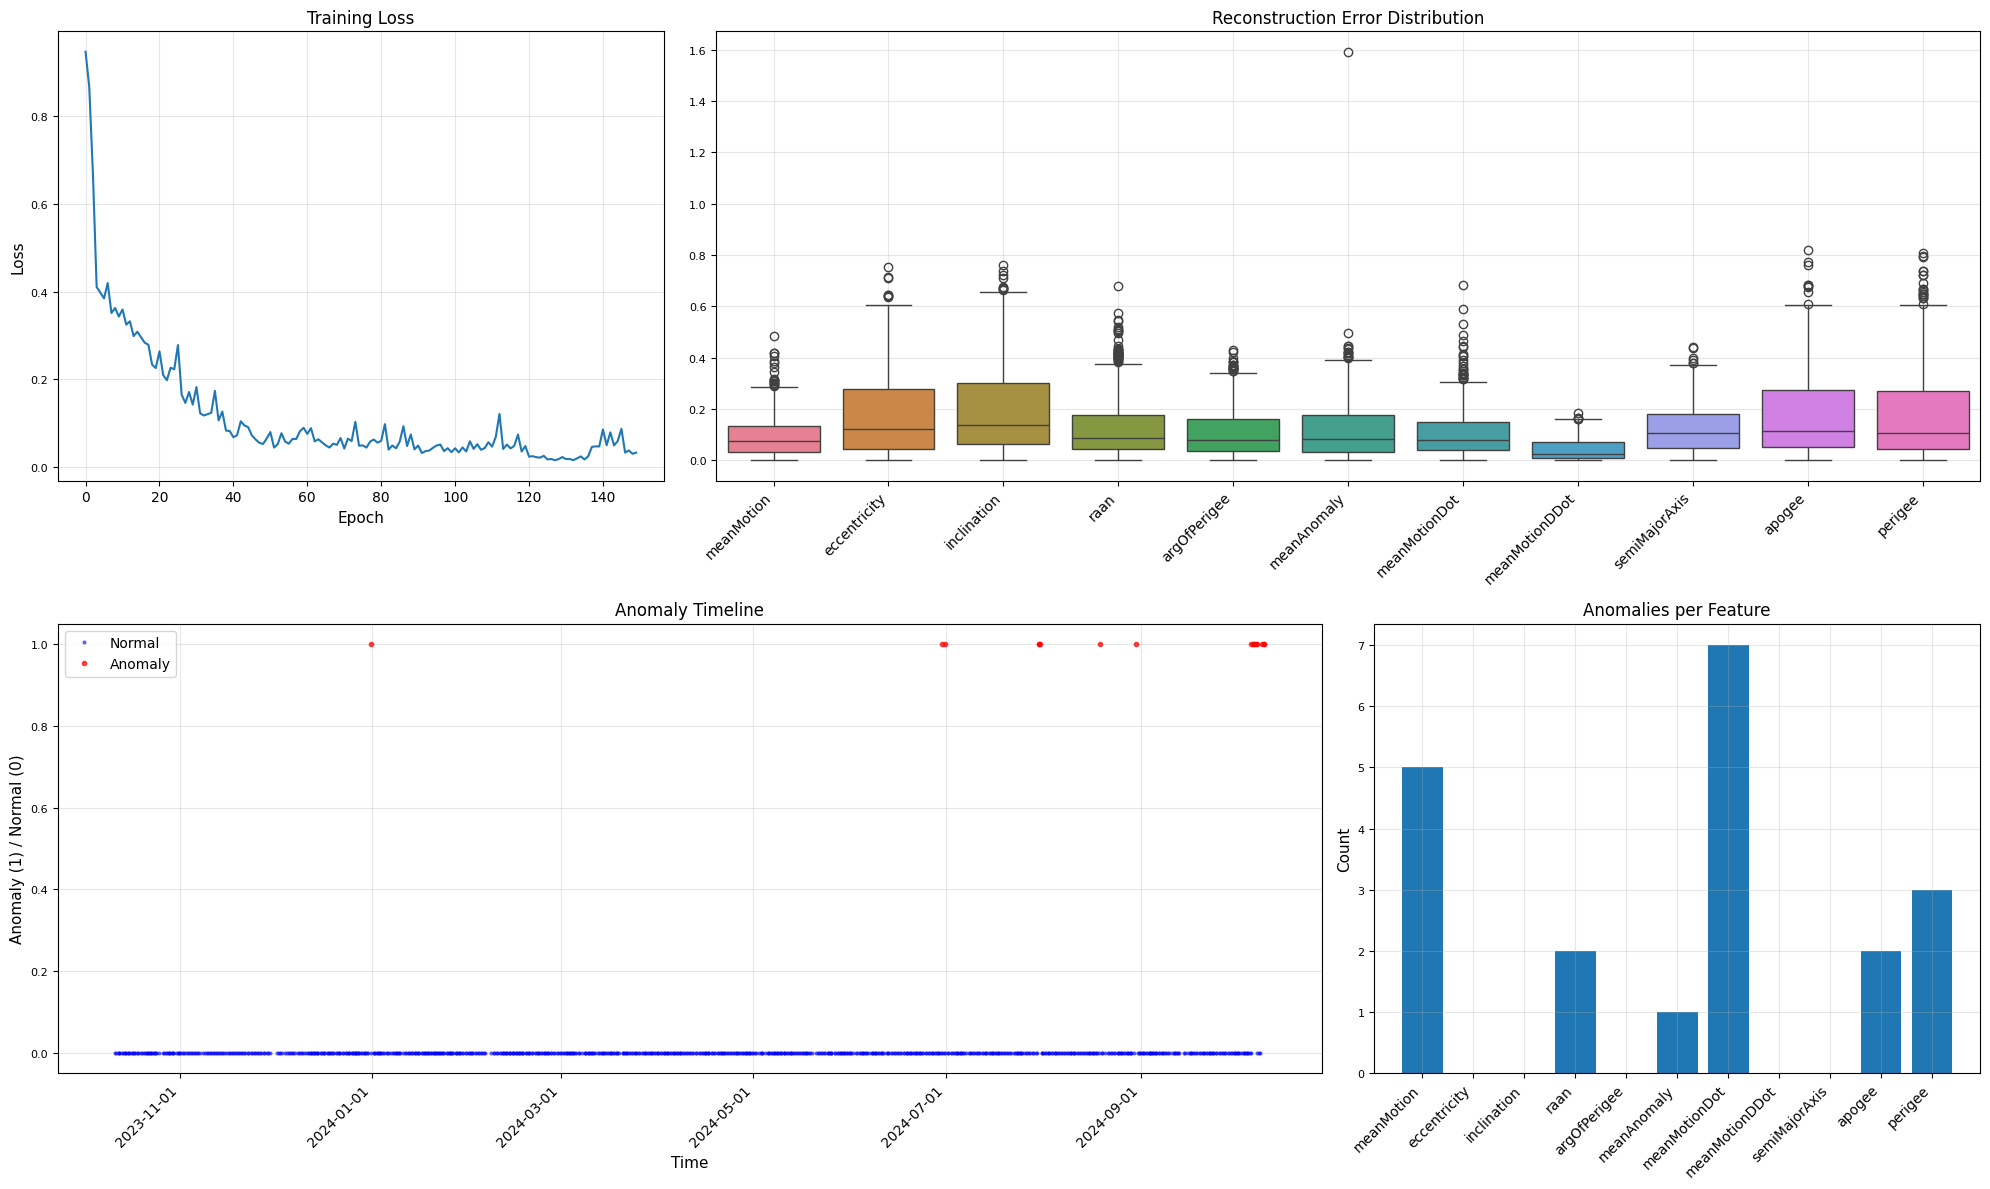

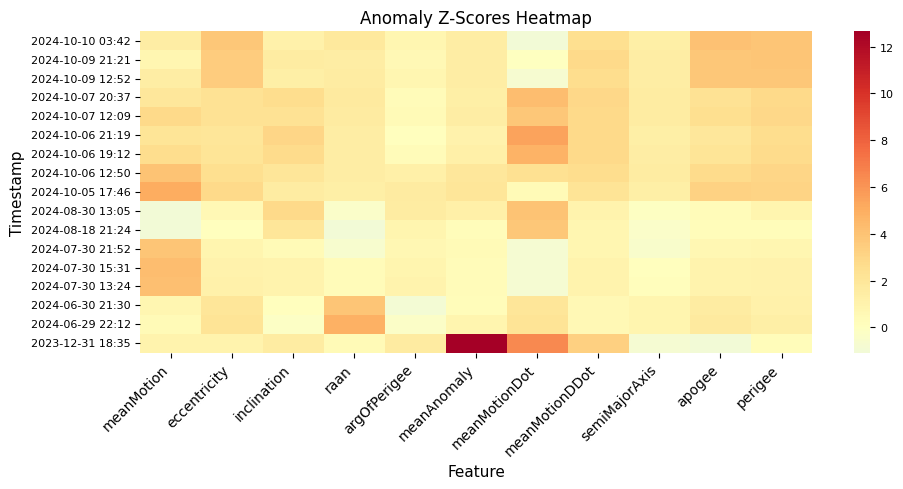

C:\Users\dk412\AppData\Local\Temp\ipykernel_18524\3782500351.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


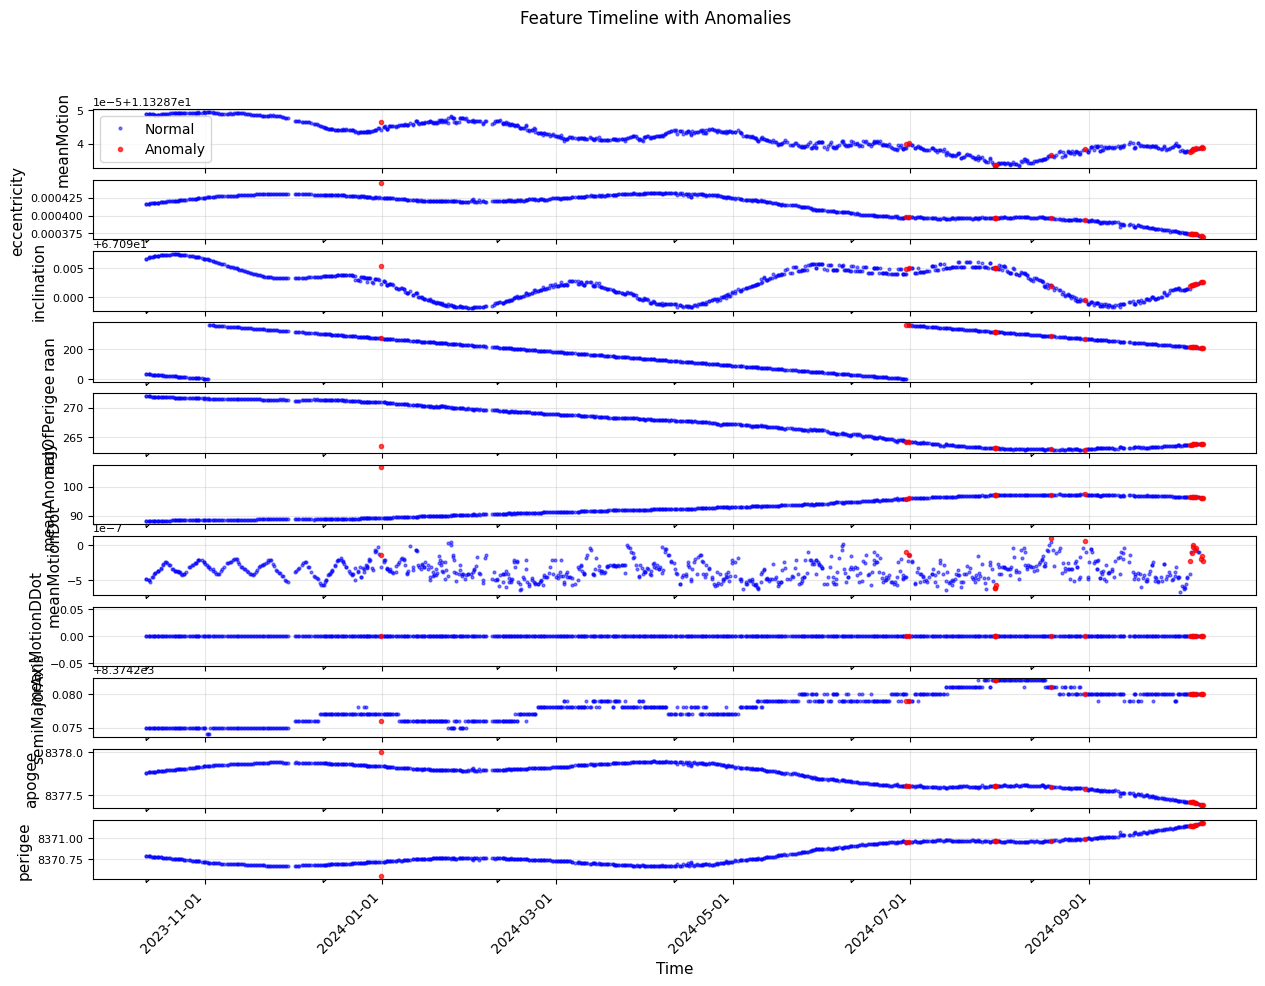


Found 17 anomalous samples

Anomaly at sample 0 on 2024-10-10:
- apogee: z-score = 4.13
- perigee: z-score = 3.94

Anomaly at sample 1 on 2024-10-09:
- perigee: z-score = 3.87

Anomaly at sample 2 on 2024-10-09:
- apogee: z-score = 3.84
- perigee: z-score = 3.84

Anomaly at sample 5 on 2024-10-07:
- meanMotionDot: z-score = 4.29

Anomaly at sample 7 on 2024-10-07:
- meanMotionDot: z-score = 3.81

Anomaly at sample 8 on 2024-10-06:
- meanMotionDot: z-score = 5.44

Anomaly at sample 9 on 2024-10-06:
- meanMotionDot: z-score = 4.79

Anomaly at sample 10 on 2024-10-06:
- meanMotion: z-score = 4.07

Anomaly at sample 12 on 2024-10-05:
- meanMotion: z-score = 5.10

Anomaly at sample 98 on 2024-08-30:
- meanMotionDot: z-score = 4.05

Anomaly at sample 123 on 2024-08-18:
- meanMotionDot: z-score = 3.79

Anomaly at sample 169 on 2024-07-30:
- meanMotion: z-score = 3.86

Anomaly at sample 170 on 2024-07-30:
- meanMotion: z-score = 4.26

Anomaly at sample 171 on 2024-07-30:
- meanMotion: z-score

In [19]:
# Define feature names (optional)
"""
feature_names = ['meanMotion',
                 'eccentricity',
                 'inclination',
                 'raan',
                 'argOfPerigee',
                 'meanAnomaly',
                 'meanMotionDot',
                 'meanMotionDDot',
                 'semiMajorAxis',
                 'apogee',
                 'perigee']
"""
feature_names = list(orb_df)
try:
    # Run the complete pipeline
    detector, anomalies, explanations, timestamps, anomaly_details = run_anomaly_detection(orb_df, feature_names)
    
    anom_dts_idx = []
    # Print results
    print(f"\nFound {sum(anomalies)} anomalous samples")
    for exp in explanations:
        print(f"\nAnomaly at sample {exp['sample_index']} on {orb_df.index[exp['sample_index']].strftime('%Y-%m-%d')}:")
        anom_dts_idx.append(exp['sample_index'])
        for feat in exp['anomalous_features']:
            print(f"- {feat['feature']}: z-score = {feat['z_score']:.2f}")
            
except Exception as e:
    print(f"Error: {str(e)}")

In [20]:
explanations

[{'sample_index': 0,
  'anomalous_features': [{'feature': 'apogee',
    'z_score': 4.130217552185059,
    'reconstruction_error': 0.819602370262146},
   {'feature': 'perigee',
    'z_score': 3.938350200653076,
    'reconstruction_error': 0.8069615364074707}]},
 {'sample_index': 1,
  'anomalous_features': [{'feature': 'perigee',
    'z_score': 3.8723108768463135,
    'reconstruction_error': 0.7962987422943115}]},
 {'sample_index': 2,
  'anomalous_features': [{'feature': 'apogee',
    'z_score': 3.8373935222625732,
    'reconstruction_error': 0.7738891839981079},
   {'feature': 'perigee',
    'z_score': 3.839460849761963,
    'reconstruction_error': 0.7909947633743286}]},
 {'sample_index': 5,
  'anomalous_features': [{'feature': 'meanMotionDot',
    'z_score': 4.294074058532715,
    'reconstruction_error': 0.4870772361755371}]},
 {'sample_index': 7,
  'anomalous_features': [{'feature': 'meanMotionDot',
    'z_score': 3.8139474391937256,
    'reconstruction_error': 0.44428813457489014}]},

In [18]:
orb_df.index[380].strftime('%Y-%m-%d')

'2024-05-01'